## Intrusion detection using anomaly detection algorithm

In [67]:
%config IPCompleter.use_jedi = False
import pandas as pd 
import cupy as cp 
import cudf
import cuml
import matplotlib.pylab as plt 
import os 
import numpy as np
from cuml.decomposition import PCA as cu_pca
import cuml.metrics as mt 
from itertools import permutations
import sklearn.metrics as sk_mt
from clx.analytics.loda import Loda

In [5]:
%matplotlib inline
cp.random.seed(101)

## Introduction 

In this workflow we show how to use Loda anomaly detector for intrusion detection usecase. We train LODA to identify attacks in the form of bots in netflow data. The benchmark dataset is taken from [cic_ids2017](https://www.unb.ca/cic/datasets/ids-2017.html). For training we use the activity collected from Monday flow data to train the detector without supervision and evaluate on Friday flow data for bots datection. Monday dat are all benign, while Friday data consists of large proportion of benign and small proportion of attacks in the form of bots. 

#### Load and preprocessing dataset

In [6]:
dir_path = "/cybermount/datasets/cic_ids2017/generated_labeled_flow_data"
datasets = os.listdir(dir_path)

In [7]:
print(datasets)

['Wednesday-workingHours.pcap_ISCX.csv', 'Tuesday-WorkingHours.pcap_ISCX.csv', 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', 'Monday-WorkingHours.pcap_ISCX.csv', 'Friday-WorkingHours-Morning.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv']


In [8]:
def load_dataset(dir_path):
    df = cudf.read_csv(dir_path) 
    df.columns = [ '_'.join(col.split()) for col in df.columns.str.strip()]
    return df
def drop_nonunique_features(df, nunique=1):
    # drop features with less than 2 unique variables. 
    var_col = []
    for i in df.columns:
        if df[i].value_counts().nunique() <= nunique:
            var_col.append(i)
    return df.drop(var_col, axis=1, inplace=False)
def remove_naninf(df):
    # Remove nan, inf rows. 
    temp_df = df.select_dtypes('float64')
    na_rows = temp_df.isin([cp.inf, cp.nan, -cp.inf]).any(1)
    return df[~na_rows]
    

We use `Monday-WorkingHours` dataset for fitting `Loda` model, this flow dataset doesn't have any attacks. For evaluation we test the trained `Loda` model on activities that contains both benign and attacks. We use `Friday-WorkingHours-Morning` that have attack in the form of bots.

In [9]:
# Training days
mon_df = load_dataset(os.path.join(dir_path, "Monday-WorkingHours.pcap_ISCX.csv")).pipe(drop_nonunique_features).pipe(remove_naninf).to_pandas()

# Testing days 
frid_df = load_dataset(os.path.join(dir_path, "Friday-WorkingHours-Morning.pcap_ISCX.csv")).pipe(drop_nonunique_features).pipe(remove_naninf).to_pandas()


In [10]:
# Proportion of anomalies in test data 
print(f"Proportion of Benign to Bots class in the evaluation dataset\n {frid_df.Label.value_counts() / frid_df.shape[0]}")

Proportion of Benign to Bots class in the evaluation dataset
 BENIGN    0.989754
Bot       0.010246
Name: Label, dtype: float64


Encode categorical columns.

#### Feature extraction and transformation methods.

We tried two approach to transform the categorical features, such as `Source_IP`, `Destination_IP`, `Source_Port`, `Destination_Port` into numerical features, so that can easily be used from Loda algorithm.
1. Transform categorical features into count/frequency format.

In [11]:
def frequent_encoding(features, df):
    
    # Econde the categorical values based on the frequency of usage normalized over all rows.
    for feature in features:
        num_unique = df[feature].nunique()
        freq_count = df.groupby(feature)[feature].count()/ num_unique
        df[feature] = df[feature].map(freq_count)
        df[feature]  = (df[feature] - df[feature].min())/(df[feature].max() - df[feature].min())
    return onehot_encode('Protocol', df)

def onehot_encode(feature, df):
    dum_protocol = cudf.get_dummies(df, columns=[feature], prefix=[feature])
    protocol = dum_protocol.iloc[:, -3:] # hard coded. 
    df = cudf.concat([df, protocol], axis=1)
    return df.drop(feature, inplace=False, axis=1)

2. Compute entropy of categorical values based on subgroups

$H(X) = -\sum_{x_i \in X} p(x_i) \log p(x_i)$ Where $p(x_i) = \frac{count(x_i)}{count(X)}$

We compute the entropy of sub-groups formed from `['Source_IP', 'Destination_IP', 'Source_Port', 'Destination_Port']` and compute all pairwise pairwise entropy among each other. Once computed append the new numeric features to the original dataframe and remove the original categorical features. 

In [12]:
def entropy(series, base=None):
    vc = series.value_counts(normalize=True, sort=False)
    return -(vc * np.log(vc)/np.log(series.shape[0])).sum()
def encode_entropy(df, feature , target):
    feature_entropy = df.groupby(feature).agg(**{
        target+"_"+feature: (target, entropy)
        })
    return df.join(feature_entropy, on=feature, rsuffix="r_")

In [13]:
cat_features = ['Source_IP', 'Destination_IP', 'Source_Port', 'Destination_Port']

In [14]:
# Encode based on entropy of pairwise of categorical features.
for feature, target in permutations(cat_features,2):
    print(feature, target)
    mon_df = encode_entropy(mon_df, feature, target)
    frid_df = encode_entropy(frid_df, feature, target)



Source_IP Destination_IP
Source_IP Source_Port
Source_IP Destination_Port
Destination_IP Source_IP
Destination_IP Source_Port
Destination_IP Destination_Port
Source_Port Source_IP
Source_Port Destination_IP
Source_Port Destination_Port
Destination_Port Source_IP
Destination_Port Destination_IP
Destination_Port Source_Port


In [15]:
def remove_categorical_features(df):
    df = df.select_dtypes(['float64','int64'])
    return df.drop(["Protocol", "Source_Port", "Destination_Port"], axis=1, inplace=False)

def remove_correlated_features(df):
    """
    param df: pd.DataFrame
    """
    corr_mat = df.corr()
    # Select upper triangle of correlation matrix
    upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))
    # Find features with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    return to_drop, df.drop(to_drop, inplace=False, axis=1)


Now remove all highly correlated features and extract label from test data for evaluation.

In [16]:
# Training data
X_train = remove_categorical_features(mon_df)
removed_cols, X_train = remove_correlated_features(X_train)


In [17]:
# Test data
label = (frid_df['Label']=="BENIGN").astype(int)
X_test = remove_categorical_features(frid_df)
X_test.drop(removed_cols, inplace=True, axis=1)

In [18]:
# Frequent_encoding 
#X_test = frequent_encoding(['Source IP', 'Destination IP', 'Source Port', 'Destination Port'], X_test.copy())

In [19]:
# Normalize if needed. 
normalize = lambda x : (x - x.min()) /(x.max() - x.min() + 0.0000001)


In [20]:
# Transform back from pandas to cudf to work with Loda. 
X_train = cudf.from_pandas(X_train)
X_test = cudf.from_pandas(X_test)

### Train and test anomaly detector.

Now we fit `Loda` to the training dataset. We can simply train the anomaly detector and generate score from the trained model. For this experiment we will fit the clean data from `Monday working hours` and generate score for the `Friday working hours`

We train `Loda` algorithm with `number_random_cuts=1000`.

In [21]:
ld = Loda(n_random_cuts=1000)

In [22]:
ld.fit(X_train.values)

In [23]:
x_scores = ld.score(X_test.values)

### Evaluation

In [55]:
# Compute metrics 
def average_precision_score(y_true, y_score):
    """
    Compute average precision score using precision and recall computed from cuml. 
    """
    precision, recall, _ = mt.precision_recall_curve(y_true, y_score) 
    # return step function integral 
    return -cp.sum(cp.diff(recall) * cp.array(precision)[:-1])

def metrics(y_true, y_score):
    auc = mt.roc_auc_score(y_true=y_true, y_score=y_score)
    ap = average_precision_score(y_true, y_score)
    return [auc, ap]

def plot_roc(label, y_scores):
    fpr, tpr, _ = sk_mt.roc_curve(y_true=label.values.tolist(), y_score=y_scores.tolist())    
    auc = metrics(label, y_scores)[0]
    plt.plot(fpr, tpr, label="ROC = " + str(np.round(auc,2)))
    plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), 'r-')
    plt.ylabel('tpr')
    plt.xlabel('fpr')
    plt.legend(loc='best')
    plt.title('Area under AUC curve')
def plot_pr(label, y_scores):
    
    ap = metrics(label, y_scores)[1]
    precision, recall, _ = mt.precision_recall_curve( label, y_scores)
    plt.plot(recall, precision, label='AP = ' + str(np.round(ap,2)))
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.legend(loc='best')
    plt.title('Area under PR curve')

In [25]:
auc, ap = metrics(label, x_scores)

In [26]:
print(f"AUC: {auc} and Average precision (AP): {ap}")

AUC: 0.544910728931427 and Average precision (AP): 0.9919086747870547


AP is good but AUC is poor, we can improve this by reducing some of the noisey features. One way is to use PCA to remove irrelevant features.

### Removing redundant features using PCA
We use `cudf` pca implementation as follows. 

In [57]:
# Reduce dimension. 
def pca_loda(x_train, x_test, variance=0.99):
    
#     if pca:
#         pca = cu_pca(n_components=n_comp, whiten=False)
#         x_train, x_test = pca.fit_transform(x_train), pca.fit_transform(x_test)
    # Fit pca and preseve percentage variance. 
    x_train, n_component = pca_transform(x_train, variance=variance)
    x_test  = cu_pca(n_components=n_component, whiten=False).fit_transform(x_test)
    
    loda_pca = Loda(n_random_cuts=500)
    loda_pca.fit(x_train)
    loda_score = loda_pca.score(x_test)
    return metrics(label, loda_score), loda_score, n_component

def pca_transform(df, variance=0.99):
    pca = cu_pca(n_components=df.shape[1])
    pca_xtrain = pca.fit_transform(df)
    variance_exp = cp.cumsum(pca.explained_variance_ratio_)
    n_components = variance_exp<=variance
    return pca_xtrain[:,n_components], sum(n_components)

In [ ]:
ap_auc, pca_scores, n_components_used = pca_loda(X_train.values, X_test.values, variance=0.999) 

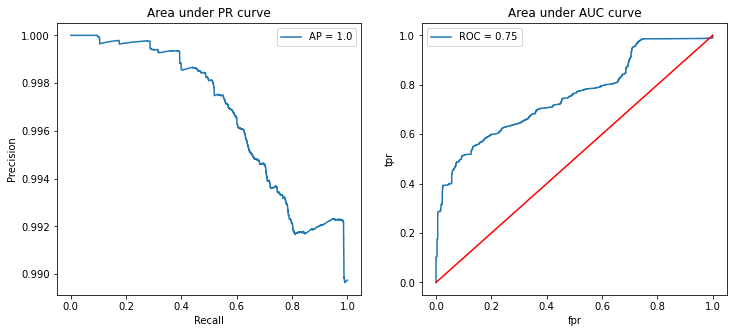

In [66]:
fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_pr(label, pca_scores)
plt.subplot(1,2,2)
plot_roc(label, pca_scores)

In [64]:
print(f"Total number features used {n_components_used}")

Total number features used 15
